In [38]:
import sys
from pathlib import Path
import yaml
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.simplefilter("ignore", FutureWarning)

from utils.field_model import *
from model_distances import vectorize_model_params

In [39]:
# load config files for data and pipeline
with open("config.yaml", "r") as f1:
    config = yaml.full_load(f1)

with open("../../data/dataset_params.yaml") as f2:
    data_params = yaml.full_load(f2)

device = torch.device(config["device"])

# dir with trajectories Datasets
traj_dir = Path("trajectories/")
if not traj_dir.exists():
    raise FileNotFoundError("No Datasets created.")

# ode models
models_dir = Path("models/")
if not models_dir.exists():
    raise FileNotFoundError("No models created.")

In [40]:
num_activities = len(data_params["activity_codes"])

distr_dict = {}
test_dict = {}

In [41]:
for activity in data_params["activity_codes"]:
    distr_dict[activity] = []

    for state_dict_file in models_dir.glob(f"{activity}*"):
        # load model
        vector_field = eval(config["model_cls"])(**config["model_params"])
        ode_model = NeuralODE(vector_field, solver='rk4').to(device)
        ode_model.load_state_dict(torch.load(state_dict_file))

        # save model params
        distr_dict[activity].append(
            vectorize_model_params(ode_model)
        )

    distr_dict[activity] = torch.stack(distr_dict[activity])

    # train/test split
    num_train_params = int(len(distr_dict[activity]) * (1 - config["test_ratio"]))
    test_dict[activity] = distr_dict[activity][num_train_params:]
    distr_dict[activity] = distr_dict[activity][:num_train_params]

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field callable (nn.Module) should ha

In [42]:
distr_dict["jog"].device

device(type='cuda', index=0)

In [43]:
# build distributions
for activity in data_params["activity_codes"]:
    activity_param_mean = distr_dict[activity].mean(dim=0)
    activity_param_cov = torch.cov(distr_dict[activity].T)

    # numerical stability
    activity_param_cov += torch.diag(1e-10 * torch.ones(activity_param_cov.shape[0])).to(activity_param_cov.device)

    distr_dict[activity] = torch.distributions.MultivariateNormal(
        activity_param_mean,
        activity_param_cov,
        validate_args=True
    )

In [44]:
# classify test models
for activity_indx, activity in enumerate(data_params["activity_codes"]):
    print(f"Classifing {activity}")

    test_params = test_dict[activity]
    probs = {}
    for activity in data_params["activity_codes"]:
        probs[activity] = distr_dict[activity].log_prob(test_params)

        print(f"Mean log prob for {activity} = {probs[activity].mean()}")

    all_probs = torch.stack(list(probs.values()))
    prediction = all_probs.argmax(dim=0)

    print(f"Accuracy = {(prediction == activity_indx).float().mean()}")

Classifing jog
Mean log prob for jog = -59370292.0
Mean log prob for std = -52910064.0
Accuracy = 0.20000000298023224
Classifing std
Mean log prob for jog = -63020892.0
Mean log prob for std = -60203516.0
Accuracy = 0.6000000238418579


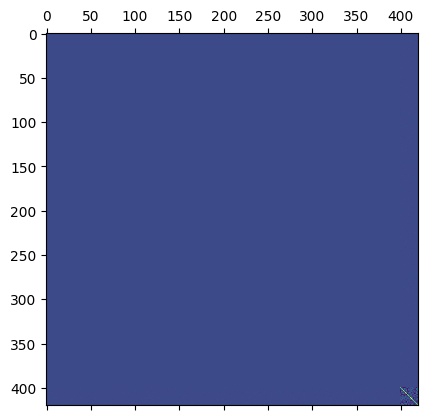

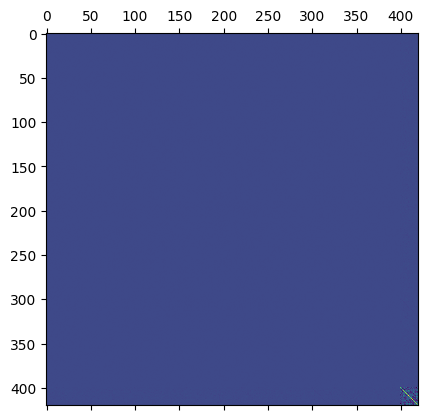

In [45]:
for activity, distr in distr_dict.items():
    plt.matshow(distr.covariance_matrix.cpu().numpy())

In [46]:
for activity, distr in distr_dict.items():
    print(distr.covariance_matrix.diag().cpu().numpy())

[2.9117725e-06 2.8091759e-05 3.1720123e-05 2.1827676e-05 3.0815900e-05
 2.5590974e-05 3.2373864e-05 2.5135099e-05 3.2813306e-05 2.5484082e-05
 3.1934465e-05 2.3761075e-05 3.1297095e-05 2.5054847e-05 2.9509198e-05
 2.2865746e-05 2.9720319e-05 2.4934810e-05 2.7194586e-05 2.4663823e-05
 2.9854991e-05 4.2020170e-06 2.2093507e-05 2.6095084e-05 2.7688002e-05
 2.5365038e-05 2.6775486e-05 2.7477539e-05 2.7513275e-05 2.3346176e-05
 2.9296882e-05 2.3317478e-05 3.2511107e-05 2.7858374e-05 2.7978893e-05
 2.9031193e-05 2.9009470e-05 1.7915210e-05 2.7523451e-05 2.4363830e-05
 3.2071603e-05 2.0891248e-05 3.8650705e-06 2.6791255e-05 2.3361665e-05
 2.5357927e-05 1.9920590e-05 3.1188923e-05 2.4519819e-05 2.8460236e-05
 3.0190642e-05 2.1170619e-05 3.2420408e-05 3.3865996e-05 2.8915929e-05
 2.0967009e-05 2.1707994e-05 2.4676850e-05 2.7892784e-05 3.1451906e-05
 2.6672149e-05 3.2395928e-05 3.3753884e-05 3.3304809e-06 2.5219286e-05
 3.5576333e-05 3.1652067e-05 2.9060513e-05 3.4991168e-05 3.4476165e-05
 3.296

In [47]:
means = list(map(
    lambda distr: distr.mean,
    distr_dict.values()
))

torch.abs(means[0] - means[1]).mean()

tensor(0.0021, device='cuda:0')

[[       0. 57059580.]
 [62680396.        0.]]


/tmp/ipykernel_51686/2971662575.py:15: RuntimeWarning: divide by zero encountered in log
  np.log(pairwise_kl)


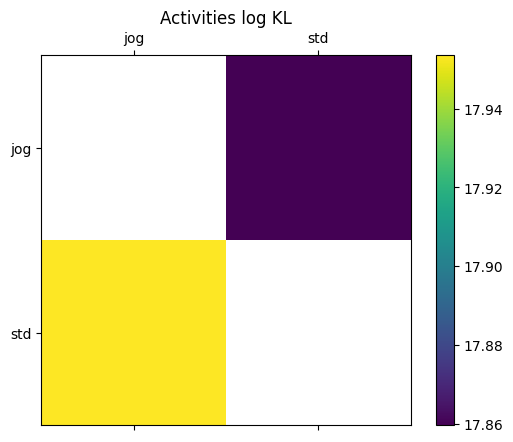

In [48]:
# vizualize kl between distributions
pairwise_kl = np.empty((num_activities, num_activities))

for i, activity_i in enumerate(data_params["activity_codes"]):
    for j, activity_j in enumerate(data_params["activity_codes"]):
        pairwise_kl[i][j] = torch.distributions.kl.kl_divergence(
            distr_dict[activity_i],
            distr_dict[activity_j]
        ).item()

print(pairwise_kl)

fig, ax = plt.subplots()
mat_pic = ax.matshow(
    np.log(pairwise_kl)
)

labels = list(data_params["activity_codes"].keys())
ax.set_xticks(np.arange(len(labels)), labels)
ax.set_yticks(np.arange(len(labels)), labels)
ax.set_title("Activities log KL")
fig.colorbar(mat_pic, ax=ax)
# fig.savefig("pairwise_kl.png")